## setup env

In [ ]:
%%capture
!pip install torch-lr-finder
!pip install einops

In [ ]:
%load_ext autoreload
%autoreload 2

## External lib
import matplotlib.pyplot as plt
import torch
import sys
import os

from torchvision import transforms
from torch import nn, optim

## Setup working env
PATH_REPO_DRIVE = ''

try:
    import google.colab
    IN_COLAB = True
    PATH_REPO_DRIVE = 'drive/MyDrive/colab/entretien/cat-vs-dog'
except:
    IN_COLAB = False

if IN_COLAB and os.getcwd()=='/content':
    from google.colab import drive
    drive.mount('/content/drive')
    sys.path.append(PATH_REPO_DRIVE)

device = torch.device(
    'cuda:0' if torch.cuda.is_available() else 'cpu'
)

Mounted at /content/drive


In [ ]:
## Internal lib
from dataset.cat_dog_dataset import CatDogDataloader, plot_images
from model.resnet import ResNet18, ResNet34, ResNet50
from utils.trainer import Trainer

In [ ]:
## Download data
%%capture
os.system(f"bash {PATH_REPO_DRIVE}/setup_data.sh")

# dataloader pipeline

In [ ]:
NUM_CHANNEL = 3
IMG_SIZE = 256
BATCH_SIZE = 16
UPSCALLING_FACTOR = 1.5

custom_transform = transforms.Compose(
    [
        transforms.RandomPerspective(distortion_scale=.4, p=.5),
        transforms.Resize(
            (
                int(IMG_SIZE*UPSCALLING_FACTOR),
                int(IMG_SIZE*UPSCALLING_FACTOR)
            )
        ),
        transforms.RandomHorizontalFlip(p=.5),
        transforms.RandomCrop(IMG_SIZE),
        transforms.RandomRotation(15),
        
        transforms.ColorJitter(
            brightness=.4,
            contrast=.4,
            saturation=.4,
            hue=.2
        ),
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0,0,0), std=(1,1,1))
    ]
)


dataloader = CatDogDataloader(
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    dataset_root = 'cats_and_dogs_filtered',
    custom_transform = custom_transform
)

In [ ]:
#saving_path = PATH_REPO_DRIVE
saving_path = None

images, _ = iter(dataloader.train_iterator).next()
plot_images(images, 'cat & dog - train', PATH_REPO_DRIVE)

images, _ = iter(dataloader.valid_iterator).next()
plot_images(images, 'cat & dog - valid')

images, _ = iter(dataloader.test_iterator).next()
plot_images(images, 'cat & dog - test', PATH_REPO_DRIVE)

# model

In [ ]:
class Squeeze(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x): return x.squeeze()

class Classifier(ResNet18):
    def __init__(self, num_classes=1):
        super(Classifier, self).__init__(num_classes=num_classes)
        
        self.fc = nn.Sequential(
            nn.Linear(512*self.block.expansion, num_classes, bias=True),
            nn.Sigmoid() if num_classes==1 else nn.Softmax(),
            Squeeze()
        )

model = Classifier(num_classes=1)

In [ ]:
model.summary(device, input_dim=(NUM_CHANNEL,IMG_SIZE,IMG_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
    ResidualBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

# training

In [ ]:
## optimizer
#optimizer = optim.SGD
optimizer = optim.Adam

## scheduler
# - cyclic
#scheduler = lambda x: optim.lr_scheduler.CyclicLR(x, base_lr=1e-4, max_lr=1e-2)
#scheduler = lambda x: optim.lr_scheduler.StepLR(x, step_size=5, gamma=.5)
scheduler = lambda x: optim.lr_scheduler.ReduceLROnPlateau(x, mode='min', factor=0.1, patience=10)

In [ ]:
trainer = Trainer(
    model=model,
    dataloader=dataloader,
    lr=1e-3,
    criterion=nn.BCELoss(),
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    root=''
)

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.67E-07


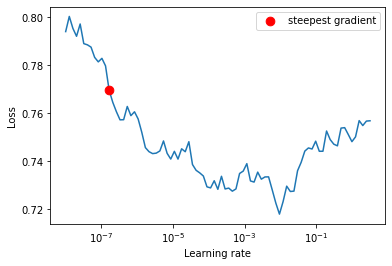

In [ ]:
saving_path = None #PATH_REPO_DRIVE

trainer.find_best_lr(end_lr=10, num_iter=100, saving_path=saving_path)

In [ ]:
trainer.clean_gpu_memory()

In [ ]:
trainer.train_data(num_epochs=300)

Epoch: 0


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.7563 Acc : 52.8761 Time: 32.3071
Valid - Loss : 0.6875 Acc : 54.8077 Time: 1.1793

Epoch: 1


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.7039 Acc : 54.0376 Time: 25.0366
Valid - Loss : 0.6665 Acc : 60.0962 Time: 1.1793

Epoch: 2


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6989 Acc : 53.8717 Time: 25.1277
Valid - Loss : 0.7019 Acc : 56.2500 Time: 1.1644

Epoch: 3


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.7008 Acc : 52.9867 Time: 26.4400
Valid - Loss : 0.6718 Acc : 60.5769 Time: 1.6278

Epoch: 4


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6897 Acc : 54.2035 Time: 25.5729
Valid - Loss : 0.6991 Acc : 48.5577 Time: 1.1649

Epoch: 5


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6874 Acc : 55.2544 Time: 25.6825
Valid - Loss : 0.6727 Acc : 62.0192 Time: 1.2065

Epoch: 6


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6937 Acc : 53.2080 Time: 25.7073
Valid - Loss : 0.7023 Acc : 61.5385 Time: 1.1861

Epoch: 7


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6933 Acc : 53.2633 Time: 25.4512
Valid - Loss : 0.6794 Acc : 50.9615 Time: 1.2055

Epoch: 8


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6861 Acc : 57.0796 Time: 25.6813
Valid - Loss : 0.6813 Acc : 57.2115 Time: 1.1859

Epoch: 9


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6850 Acc : 57.4115 Time: 25.5833
Valid - Loss : 0.6602 Acc : 62.9808 Time: 1.1695

Epoch: 10


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6821 Acc : 57.5774 Time: 25.2708
Valid - Loss : 0.6582 Acc : 68.7500 Time: 1.1919

Epoch: 11


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6820 Acc : 56.0288 Time: 25.2154
Valid - Loss : 0.6636 Acc : 63.9423 Time: 1.1908

Epoch: 12


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6775 Acc : 56.3606 Time: 25.4616
Valid - Loss : 0.6478 Acc : 63.4615 Time: 1.1383

Epoch: 13


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6807 Acc : 55.6416 Time: 25.3748
Valid - Loss : 0.6785 Acc : 61.5385 Time: 1.1980

Epoch: 14


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6830 Acc : 56.4159 Time: 25.1170
Valid - Loss : 0.6675 Acc : 64.4231 Time: 1.1435

Epoch: 15


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6732 Acc : 58.2965 Time: 25.2012
Valid - Loss : 0.6709 Acc : 63.4615 Time: 1.1671

Epoch: 16


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6768 Acc : 57.5221 Time: 25.2981
Valid - Loss : 0.6530 Acc : 65.3846 Time: 1.1830

Epoch: 17


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6764 Acc : 57.2456 Time: 25.1579
Valid - Loss : 0.6541 Acc : 62.9808 Time: 1.1785

Epoch: 18


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6847 Acc : 55.6969 Time: 25.2719
Valid - Loss : 0.6573 Acc : 62.9808 Time: 1.1757

Epoch: 19


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6724 Acc : 57.4115 Time: 25.2220
Valid - Loss : 0.6580 Acc : 58.6538 Time: 1.1773

Epoch: 20


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6750 Acc : 57.0243 Time: 25.2389
Valid - Loss : 0.6544 Acc : 65.3846 Time: 1.1844

Epoch: 21


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6707 Acc : 59.1814 Time: 25.2605
Valid - Loss : 0.6675 Acc : 60.0962 Time: 1.1793

Epoch: 22


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6693 Acc : 59.8451 Time: 25.1895
Valid - Loss : 0.6385 Acc : 67.3077 Time: 1.1583

Epoch: 23


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6713 Acc : 57.6881 Time: 25.2629
Valid - Loss : 0.6220 Acc : 68.2692 Time: 1.1956

Epoch: 24


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6649 Acc : 60.5088 Time: 24.7827
Valid - Loss : 0.6146 Acc : 69.2308 Time: 1.1725

Epoch: 25


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6675 Acc : 59.7898 Time: 25.3490
Valid - Loss : 0.6353 Acc : 67.3077 Time: 1.1845

Epoch: 26


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6554 Acc : 61.9469 Time: 25.2997
Valid - Loss : 0.6688 Acc : 61.5385 Time: 1.1779

Epoch: 27


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6569 Acc : 61.5597 Time: 25.4530
Valid - Loss : 0.6492 Acc : 60.5769 Time: 1.1792

Epoch: 28


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6587 Acc : 60.0664 Time: 25.3939
Valid - Loss : 0.6417 Acc : 70.1923 Time: 1.1941

Epoch: 29


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6582 Acc : 60.7301 Time: 25.0019
Valid - Loss : 0.6214 Acc : 68.2692 Time: 1.1827

Epoch: 30


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6504 Acc : 62.0575 Time: 25.5434
Valid - Loss : 0.6301 Acc : 69.2308 Time: 1.1764

Epoch: 31


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6518 Acc : 62.9978 Time: 25.5783
Valid - Loss : 0.6494 Acc : 68.2692 Time: 1.1676

Epoch: 32


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6636 Acc : 61.0619 Time: 25.4211
Valid - Loss : 0.6375 Acc : 63.4615 Time: 1.1550

Epoch: 33


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6453 Acc : 63.4956 Time: 25.4830
Valid - Loss : 0.6322 Acc : 66.8269 Time: 1.2063

Epoch: 34


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6421 Acc : 64.1593 Time: 25.1997
Valid - Loss : 0.5809 Acc : 72.5962 Time: 1.1769

Epoch: 35


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6349 Acc : 64.5465 Time: 25.5088
Valid - Loss : 0.6481 Acc : 63.9423 Time: 1.1820

Epoch: 36


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6362 Acc : 63.9934 Time: 25.4747
Valid - Loss : 0.6103 Acc : 70.6731 Time: 1.1871

Epoch: 37


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6235 Acc : 64.8783 Time: 25.3721
Valid - Loss : 0.6123 Acc : 71.1538 Time: 1.2014

Epoch: 38


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6359 Acc : 64.2146 Time: 25.6929
Valid - Loss : 0.6361 Acc : 60.0962 Time: 1.2137

Epoch: 39


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6229 Acc : 64.6018 Time: 25.9459
Valid - Loss : 0.6078 Acc : 67.3077 Time: 1.2141

Epoch: 40


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6249 Acc : 65.2655 Time: 25.8990
Valid - Loss : 0.6007 Acc : 67.7885 Time: 1.1881

Epoch: 41


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6129 Acc : 66.5929 Time: 25.5764
Valid - Loss : 0.6059 Acc : 66.8269 Time: 1.1889

Epoch: 42


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6153 Acc : 66.6482 Time: 25.6482
Valid - Loss : 0.5955 Acc : 70.1923 Time: 1.2085

Epoch: 43


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6138 Acc : 66.3164 Time: 25.8223
Valid - Loss : 0.6107 Acc : 68.2692 Time: 1.1795

Epoch: 44


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6037 Acc : 67.9204 Time: 25.7339
Valid - Loss : 0.6220 Acc : 66.8269 Time: 1.1843

Epoch: 45


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6043 Acc : 68.9712 Time: 25.6411
Valid - Loss : 0.5463 Acc : 76.4423 Time: 1.1954

Epoch: 46


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.5939 Acc : 68.1416 Time: 25.3318
Valid - Loss : 0.5922 Acc : 68.7500 Time: 1.1900

Epoch: 47


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.6010 Acc : 69.1925 Time: 25.5681
Valid - Loss : 0.5742 Acc : 70.6731 Time: 1.1684

Epoch: 48


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.5738 Acc : 70.5752 Time: 25.3808
Valid - Loss : 0.5637 Acc : 72.1154 Time: 1.1826

Epoch: 49


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.5746 Acc : 70.9071 Time: 25.0360
Valid - Loss : 0.5731 Acc : 73.0769 Time: 1.1752

Epoch: 50


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.5991 Acc : 67.6991 Time: 25.1034
Valid - Loss : 0.5826 Acc : 68.2692 Time: 1.1796

Epoch: 51


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.5769 Acc : 71.1836 Time: 25.2766
Valid - Loss : 0.5171 Acc : 72.5962 Time: 1.1898

Epoch: 52


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.5519 Acc : 71.8473 Time: 24.9688
Valid - Loss : 0.5852 Acc : 73.5577 Time: 1.1753

Epoch: 53


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.5465 Acc : 72.7323 Time: 25.3118
Valid - Loss : 0.5588 Acc : 69.7115 Time: 1.1630

Epoch: 54


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.5622 Acc : 71.0730 Time: 24.9267
Valid - Loss : 0.5500 Acc : 74.0385 Time: 1.1689

Epoch: 55


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.5388 Acc : 74.2257 Time: 25.2318
Valid - Loss : 0.5934 Acc : 68.7500 Time: 1.2020

Epoch: 56


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.5540 Acc : 72.2898 Time: 25.1276
Valid - Loss : 0.5294 Acc : 75.4808 Time: 1.1743

Epoch: 57


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.5498 Acc : 72.4558 Time: 24.7345
Valid - Loss : 0.5331 Acc : 71.1538 Time: 1.1557

Epoch: 58


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.5557 Acc : 72.0133 Time: 24.8795
Valid - Loss : 0.5032 Acc : 79.3269 Time: 1.1760

Epoch: 59


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.5383 Acc : 73.8938 Time: 24.9038
Valid - Loss : 0.5130 Acc : 74.5192 Time: 1.1676

Epoch: 60


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.5287 Acc : 74.7235 Time: 25.1076
Valid - Loss : 0.5520 Acc : 65.8654 Time: 1.1826

Epoch: 61


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.5027 Acc : 75.8850 Time: 25.1112
Valid - Loss : 0.5185 Acc : 75.9615 Time: 1.1633

Epoch: 62


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.5317 Acc : 72.2898 Time: 24.7245
Valid - Loss : 0.4872 Acc : 77.4038 Time: 1.1543

Epoch: 63


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.5014 Acc : 75.9403 Time: 25.0155
Valid - Loss : 0.5085 Acc : 74.5192 Time: 1.1851

Epoch: 64


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.5042 Acc : 75.8850 Time: 24.8688
Valid - Loss : 0.4884 Acc : 77.8846 Time: 1.1746

Epoch: 65


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.4988 Acc : 76.2721 Time: 25.0829
Valid - Loss : 0.4687 Acc : 79.3269 Time: 1.1658

Epoch: 66


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.5104 Acc : 75.5531 Time: 24.8562
Valid - Loss : 0.5437 Acc : 73.5577 Time: 1.2060

Epoch: 67


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.4869 Acc : 75.6084 Time: 25.1727
Valid - Loss : 0.5435 Acc : 72.5962 Time: 1.1783

Epoch: 68


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.4833 Acc : 76.4934 Time: 24.9599
Valid - Loss : 0.5153 Acc : 78.8462 Time: 1.1784

Epoch: 69


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.5128 Acc : 75.1106 Time: 25.2445
Valid - Loss : 0.5001 Acc : 74.5192 Time: 1.1610

Epoch: 70


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.4777 Acc : 76.6040 Time: 25.2556
Valid - Loss : 0.4684 Acc : 80.2885 Time: 1.1544

Epoch: 71


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.4808 Acc : 76.8805 Time: 24.9347
Valid - Loss : 0.4731 Acc : 79.3269 Time: 1.1625

Epoch: 72


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.4653 Acc : 77.8761 Time: 25.1689
Valid - Loss : 0.5540 Acc : 73.0769 Time: 1.1757

Epoch: 73


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.4654 Acc : 78.5398 Time: 25.1806
Valid - Loss : 0.4748 Acc : 78.3654 Time: 1.3241

Epoch: 74


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.4529 Acc : 78.9270 Time: 24.8232
Valid - Loss : 0.5539 Acc : 73.5577 Time: 1.3017

Epoch: 75


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.4537 Acc : 79.5907 Time: 25.1950
Valid - Loss : 0.4991 Acc : 72.5962 Time: 1.3117

Epoch: 76


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.4512 Acc : 78.8717 Time: 24.8249
Valid - Loss : 0.4580 Acc : 77.8846 Time: 1.3155

Epoch: 77


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.4538 Acc : 79.4801 Time: 25.2311
Valid - Loss : 0.4984 Acc : 75.9615 Time: 1.3136

Epoch: 78


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.4358 Acc : 80.2544 Time: 25.6282
Valid - Loss : 0.5090 Acc : 75.9615 Time: 1.1632

Epoch: 79


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.4348 Acc : 80.5863 Time: 24.9463
Valid - Loss : 0.5095 Acc : 74.5192 Time: 1.1750

Epoch: 80


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.4201 Acc : 79.8119 Time: 24.6156
Valid - Loss : 0.4898 Acc : 78.3654 Time: 1.2059

Epoch: 81


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.4208 Acc : 80.1991 Time: 24.7766
Valid - Loss : 0.4029 Acc : 78.8462 Time: 1.1698

Epoch: 82


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.4375 Acc : 79.9226 Time: 24.8192
Valid - Loss : 0.4512 Acc : 76.9231 Time: 1.1884

Epoch: 83


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.4185 Acc : 81.2500 Time: 25.1077
Valid - Loss : 0.4598 Acc : 79.8077 Time: 1.1640

Epoch: 84


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.4274 Acc : 79.6460 Time: 24.9035
Valid - Loss : 0.5012 Acc : 75.4808 Time: 1.1591

Epoch: 85


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.4324 Acc : 81.1947 Time: 24.9311
Valid - Loss : 0.4340 Acc : 79.8077 Time: 1.1854

Epoch: 86


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3981 Acc : 82.1350 Time: 24.8771
Valid - Loss : 0.4083 Acc : 80.7692 Time: 1.1384

Epoch: 87


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.4001 Acc : 81.6925 Time: 24.8272
Valid - Loss : 0.4282 Acc : 78.8462 Time: 1.1803

Epoch: 88


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3995 Acc : 81.9690 Time: 25.0073
Valid - Loss : 0.4662 Acc : 78.8462 Time: 1.1672

Epoch: 89


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3939 Acc : 82.3562 Time: 25.0055
Valid - Loss : 0.4288 Acc : 79.8077 Time: 1.1603

Epoch: 90


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3876 Acc : 82.3009 Time: 24.9610
Valid - Loss : 0.3898 Acc : 81.7308 Time: 1.1809

Epoch: 91


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3841 Acc : 82.6881 Time: 24.7894
Valid - Loss : 0.4549 Acc : 79.8077 Time: 1.1618

Epoch: 92


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3957 Acc : 82.0243 Time: 25.0717
Valid - Loss : 0.4039 Acc : 81.7308 Time: 1.1696

Epoch: 93


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3776 Acc : 82.9093 Time: 24.9899
Valid - Loss : 0.4220 Acc : 79.8077 Time: 1.1576

Epoch: 94


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3742 Acc : 83.1305 Time: 25.0277
Valid - Loss : 0.4046 Acc : 79.8077 Time: 1.1597

Epoch: 95


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3659 Acc : 82.5221 Time: 25.5153
Valid - Loss : 0.3805 Acc : 81.7308 Time: 1.1875

Epoch: 96


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3508 Acc : 84.8451 Time: 24.9807
Valid - Loss : 0.3834 Acc : 80.7692 Time: 1.1614

Epoch: 97


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3672 Acc : 83.1305 Time: 25.0406
Valid - Loss : 0.3931 Acc : 80.7692 Time: 1.1607

Epoch: 98


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3519 Acc : 85.1770 Time: 25.1019
Valid - Loss : 0.3933 Acc : 79.3269 Time: 1.1452

Epoch: 99


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3542 Acc : 83.8496 Time: 25.0098
Valid - Loss : 0.3681 Acc : 82.2115 Time: 1.1794

Epoch: 100


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3675 Acc : 83.1858 Time: 25.2606
Valid - Loss : 0.3526 Acc : 81.7308 Time: 1.1693

Epoch: 101


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3299 Acc : 85.1770 Time: 25.0388
Valid - Loss : 0.3850 Acc : 84.6154 Time: 1.2244

Epoch: 102


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3417 Acc : 84.9558 Time: 25.0860
Valid - Loss : 0.4397 Acc : 81.7308 Time: 1.1757

Epoch: 103


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3283 Acc : 86.1173 Time: 24.9765
Valid - Loss : 0.3974 Acc : 80.2885 Time: 1.1994

Epoch: 104


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3350 Acc : 84.8451 Time: 24.9411
Valid - Loss : 0.3993 Acc : 81.7308 Time: 1.1657

Epoch: 105


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3303 Acc : 85.9513 Time: 25.1921
Valid - Loss : 0.4163 Acc : 83.6538 Time: 1.1600

Epoch: 106


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3481 Acc : 84.4580 Time: 25.1408
Valid - Loss : 0.4326 Acc : 79.3269 Time: 1.1719

Epoch: 107


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3420 Acc : 85.0664 Time: 25.0688
Valid - Loss : 0.3607 Acc : 84.1346 Time: 1.1733

Epoch: 108


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3120 Acc : 86.1173 Time: 25.0921
Valid - Loss : 0.3904 Acc : 81.7308 Time: 1.1523

Epoch: 109


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3194 Acc : 86.5044 Time: 25.2158
Valid - Loss : 0.3475 Acc : 81.7308 Time: 1.1912

Epoch: 110


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3219 Acc : 86.0066 Time: 25.3145
Valid - Loss : 0.3144 Acc : 87.0192 Time: 1.1747

Epoch: 111


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3223 Acc : 86.1173 Time: 24.9607
Valid - Loss : 0.3222 Acc : 84.6154 Time: 1.1569

Epoch: 112


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3181 Acc : 86.7257 Time: 25.1546
Valid - Loss : 0.3726 Acc : 84.1346 Time: 1.1914

Epoch: 113


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3184 Acc : 87.0575 Time: 24.9814
Valid - Loss : 0.3208 Acc : 82.6923 Time: 1.1716

Epoch: 114


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2823 Acc : 88.1084 Time: 24.8806
Valid - Loss : 0.3488 Acc : 82.6923 Time: 1.1591

Epoch: 115


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3001 Acc : 87.5553 Time: 24.8110
Valid - Loss : 0.3453 Acc : 86.5385 Time: 1.1995

Epoch: 116


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3169 Acc : 87.0575 Time: 25.0098
Valid - Loss : 0.3339 Acc : 84.1346 Time: 1.1719

Epoch: 117


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2759 Acc : 87.8872 Time: 25.2229
Valid - Loss : 0.3620 Acc : 84.6154 Time: 1.2215

Epoch: 118


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.3045 Acc : 87.0575 Time: 25.2419
Valid - Loss : 0.3031 Acc : 86.0577 Time: 1.1891

Epoch: 119


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2972 Acc : 86.9469 Time: 25.2131
Valid - Loss : 0.3016 Acc : 85.5769 Time: 1.1893

Epoch: 120


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2799 Acc : 88.0531 Time: 25.5258
Valid - Loss : 0.3313 Acc : 85.0962 Time: 1.1440

Epoch: 121


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2726 Acc : 87.9978 Time: 25.2141
Valid - Loss : 0.3562 Acc : 81.7308 Time: 1.1559

Epoch: 122


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2689 Acc : 88.8827 Time: 25.1227
Valid - Loss : 0.3229 Acc : 84.6154 Time: 1.2054

Epoch: 123


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2581 Acc : 89.3805 Time: 25.2376
Valid - Loss : 0.3252 Acc : 85.5769 Time: 1.1850

Epoch: 124


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2891 Acc : 87.7765 Time: 25.4572
Valid - Loss : 0.3125 Acc : 86.5385 Time: 1.1601

Epoch: 125


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2577 Acc : 88.9934 Time: 25.1311
Valid - Loss : 0.3273 Acc : 86.0577 Time: 1.1801

Epoch: 126


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2586 Acc : 88.3850 Time: 25.1963
Valid - Loss : 0.2638 Acc : 88.4615 Time: 1.1685

Epoch: 127


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2529 Acc : 89.2699 Time: 25.4775
Valid - Loss : 0.3558 Acc : 84.1346 Time: 1.1603

Epoch: 128


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2419 Acc : 89.5465 Time: 25.3240
Valid - Loss : 0.3063 Acc : 90.8654 Time: 1.1687

Epoch: 129


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2484 Acc : 88.7168 Time: 25.3056
Valid - Loss : 0.3618 Acc : 85.0962 Time: 1.1945

Epoch: 130


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2576 Acc : 89.3252 Time: 25.2827
Valid - Loss : 0.2957 Acc : 89.4231 Time: 1.1801

Epoch: 131


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2415 Acc : 89.6018 Time: 25.0788
Valid - Loss : 0.2990 Acc : 87.5000 Time: 1.1822

Epoch: 132


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2533 Acc : 89.5465 Time: 25.1995
Valid - Loss : 0.3000 Acc : 84.1346 Time: 1.1738

Epoch: 133


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2525 Acc : 89.3252 Time: 25.0962
Valid - Loss : 0.3228 Acc : 88.9423 Time: 1.1750

Epoch: 134


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2337 Acc : 90.4314 Time: 25.1144
Valid - Loss : 0.3092 Acc : 87.0192 Time: 1.1770

Epoch: 135


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2388 Acc : 89.6018 Time: 25.1925
Valid - Loss : 0.3386 Acc : 85.0962 Time: 1.1839

Epoch: 136


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2349 Acc : 89.2146 Time: 24.9155
Valid - Loss : 0.2713 Acc : 87.5000 Time: 1.2014

Epoch: 137


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2414 Acc : 89.5465 Time: 25.0186
Valid - Loss : 0.3087 Acc : 85.5769 Time: 1.2096

Epoch: 138


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2319 Acc : 90.1549 Time: 25.1970
Valid - Loss : 0.3322 Acc : 85.5769 Time: 1.1590

Epoch: 139


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2415 Acc : 89.2699 Time: 25.2192
Valid - Loss : 0.2455 Acc : 89.9038 Time: 1.1558

Epoch: 140


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2130 Acc : 90.7080 Time: 25.1798
Valid - Loss : 0.2492 Acc : 90.8654 Time: 1.1932

Epoch: 141


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2433 Acc : 89.1593 Time: 25.6524
Valid - Loss : 0.2936 Acc : 89.9038 Time: 1.2273

Epoch: 142


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2291 Acc : 90.2102 Time: 26.0919
Valid - Loss : 0.2792 Acc : 87.9808 Time: 1.2073

Epoch: 143


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2446 Acc : 90.0442 Time: 25.0598
Valid - Loss : 0.2871 Acc : 85.0962 Time: 1.1458

Epoch: 144


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2094 Acc : 91.6482 Time: 25.1410
Valid - Loss : 0.3080 Acc : 87.0192 Time: 1.1564

Epoch: 145


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2247 Acc : 91.0398 Time: 24.9926
Valid - Loss : 0.2824 Acc : 89.9038 Time: 1.1751

Epoch: 146


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2144 Acc : 91.0398 Time: 25.0528
Valid - Loss : 0.3763 Acc : 84.1346 Time: 1.1829

Epoch: 147


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2106 Acc : 91.6482 Time: 25.1668
Valid - Loss : 0.3719 Acc : 82.6923 Time: 1.1796

Epoch: 148


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2149 Acc : 91.2611 Time: 25.0339
Valid - Loss : 0.2954 Acc : 88.4615 Time: 1.1525

Epoch: 149


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2083 Acc : 92.0354 Time: 25.1159
Valid - Loss : 0.4337 Acc : 84.6154 Time: 1.1421

Epoch: 150


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2275 Acc : 91.3164 Time: 25.0136
Valid - Loss : 0.3217 Acc : 85.5769 Time: 1.1948

Epoch: 151


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2024 Acc : 91.7035 Time: 25.3529
Valid - Loss : 0.2610 Acc : 89.9038 Time: 1.1569

Epoch: 152


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2066 Acc : 90.8739 Time: 25.2361
Valid - Loss : 0.2529 Acc : 88.4615 Time: 1.1904

Epoch: 153


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1848 Acc : 92.1460 Time: 25.2164
Valid - Loss : 0.2977 Acc : 86.5385 Time: 1.1571

Epoch: 154


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1911 Acc : 92.3119 Time: 25.6156
Valid - Loss : 0.3553 Acc : 82.6923 Time: 1.2065

Epoch: 155


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1978 Acc : 91.2611 Time: 25.0797
Valid - Loss : 0.3078 Acc : 85.5769 Time: 1.1804

Epoch: 156


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2214 Acc : 90.2655 Time: 25.2075
Valid - Loss : 0.2800 Acc : 87.5000 Time: 1.1629

Epoch: 157


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.2000 Acc : 91.7588 Time: 25.5904
Valid - Loss : 0.2980 Acc : 87.0192 Time: 1.1710

Epoch: 158


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1999 Acc : 91.5929 Time: 25.1680
Valid - Loss : 0.3177 Acc : 84.1346 Time: 1.1700

Epoch: 159


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1930 Acc : 91.9801 Time: 25.4978
Valid - Loss : 0.3375 Acc : 88.9423 Time: 1.1979

Epoch: 160


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1902 Acc : 92.4779 Time: 24.8617
Valid - Loss : 0.3043 Acc : 86.5385 Time: 1.1566

Epoch: 161


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1763 Acc : 93.1969 Time: 24.8228
Valid - Loss : 0.2640 Acc : 88.4615 Time: 1.1718

Epoch: 162


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1762 Acc : 93.0310 Time: 25.5071
Valid - Loss : 0.2686 Acc : 86.5385 Time: 1.1695

Epoch: 163


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1849 Acc : 92.3673 Time: 25.4416
Valid - Loss : 0.2830 Acc : 91.3462 Time: 1.1424

Epoch: 164


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1834 Acc : 93.1416 Time: 25.3467
Valid - Loss : 0.2667 Acc : 88.4615 Time: 1.2084

Epoch: 165


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1682 Acc : 93.1969 Time: 25.2115
Valid - Loss : 0.3038 Acc : 89.4231 Time: 1.1956

Epoch: 166


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1593 Acc : 93.1416 Time: 24.9308
Valid - Loss : 0.2724 Acc : 88.9423 Time: 1.1832

Epoch: 167


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1737 Acc : 92.5885 Time: 25.2800
Valid - Loss : 0.3438 Acc : 87.9808 Time: 1.1931

Epoch: 168


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1545 Acc : 94.4690 Time: 25.3236
Valid - Loss : 0.2923 Acc : 88.4615 Time: 1.1673

Epoch: 169


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1862 Acc : 92.5885 Time: 25.2493
Valid - Loss : 0.3444 Acc : 88.9423 Time: 1.1771

Epoch: 170


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1531 Acc : 93.3075 Time: 25.1954
Valid - Loss : 0.2295 Acc : 90.8654 Time: 1.1810

Epoch: 171


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1674 Acc : 93.4735 Time: 25.0796
Valid - Loss : 0.2620 Acc : 89.9038 Time: 1.1719

Epoch: 172


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1655 Acc : 92.8650 Time: 25.2488
Valid - Loss : 0.3208 Acc : 87.5000 Time: 1.1937

Epoch: 173


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1576 Acc : 93.8053 Time: 24.8208
Valid - Loss : 0.3235 Acc : 85.5769 Time: 1.1748

Epoch: 174


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1531 Acc : 93.5841 Time: 25.3460
Valid - Loss : 0.2866 Acc : 90.3846 Time: 1.1760

Epoch: 175


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1705 Acc : 92.9204 Time: 25.0976
Valid - Loss : 0.2380 Acc : 90.8654 Time: 1.1444

Epoch: 176


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1557 Acc : 93.8606 Time: 25.6580
Valid - Loss : 0.3076 Acc : 90.3846 Time: 1.1949

Epoch: 177


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1548 Acc : 93.5841 Time: 25.1345
Valid - Loss : 0.2807 Acc : 88.9423 Time: 1.1949

Epoch: 178


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1593 Acc : 93.3075 Time: 25.3655
Valid - Loss : 0.2824 Acc : 89.9038 Time: 1.1537

Epoch: 179


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1441 Acc : 94.1925 Time: 25.1604
Valid - Loss : 0.2507 Acc : 88.9423 Time: 1.1794

Epoch: 180


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1419 Acc : 94.6350 Time: 25.3356
Valid - Loss : 0.2595 Acc : 89.4231 Time: 1.1650

Epoch: 181


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1416 Acc : 94.6350 Time: 25.2435
Valid - Loss : 0.2585 Acc : 89.4231 Time: 1.1762

Epoch: 182


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1455 Acc : 94.2478 Time: 25.3383
Valid - Loss : 0.3246 Acc : 89.9038 Time: 1.1700

Epoch: 183


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1593 Acc : 93.1416 Time: 25.0707
Valid - Loss : 0.2920 Acc : 89.9038 Time: 1.1945

Epoch: 184


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1290 Acc : 95.1327 Time: 24.9584
Valid - Loss : 0.3316 Acc : 87.0192 Time: 1.1547

Epoch: 185


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1505 Acc : 93.6394 Time: 25.2446
Valid - Loss : 0.2656 Acc : 88.9423 Time: 1.1881

Epoch: 186


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1425 Acc : 94.6903 Time: 25.0993
Valid - Loss : 0.3112 Acc : 89.4231 Time: 1.1960

Epoch: 187


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1710 Acc : 92.5332 Time: 25.2092
Valid - Loss : 0.3129 Acc : 87.5000 Time: 1.1709

Epoch: 188


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1397 Acc : 94.8009 Time: 25.1332
Valid - Loss : 0.3279 Acc : 89.4231 Time: 1.1515

Epoch: 189


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1264 Acc : 95.0774 Time: 25.6337
Valid - Loss : 0.3429 Acc : 87.5000 Time: 1.2202

Epoch: 190


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1375 Acc : 94.6350 Time: 25.6130
Valid - Loss : 0.3088 Acc : 89.9038 Time: 1.1858

Epoch: 191


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1668 Acc : 92.9204 Time: 25.6275
Valid - Loss : 0.2348 Acc : 89.4231 Time: 1.1975

Epoch: 192


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1295 Acc : 94.8009 Time: 25.3051
Valid - Loss : 0.2954 Acc : 90.3846 Time: 1.1885

Epoch: 193


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1306 Acc : 95.2434 Time: 25.2881
Valid - Loss : 0.3055 Acc : 89.9038 Time: 1.1658

Epoch: 194


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1213 Acc : 95.0774 Time: 25.8003
Valid - Loss : 0.4198 Acc : 86.0577 Time: 1.2107

Epoch: 195


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1500 Acc : 94.1925 Time: 25.3927
Valid - Loss : 0.3571 Acc : 87.0192 Time: 1.1731

Epoch: 196


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1222 Acc : 95.2987 Time: 25.3290
Valid - Loss : 0.2917 Acc : 90.3846 Time: 1.1647

Epoch: 197


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1403 Acc : 94.5243 Time: 25.2008
Valid - Loss : 0.3691 Acc : 89.9038 Time: 1.2073

Epoch: 198


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1385 Acc : 94.9668 Time: 25.0634
Valid - Loss : 0.4351 Acc : 84.1346 Time: 1.1672

Epoch: 199


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1400 Acc : 94.0819 Time: 25.5747
Valid - Loss : 0.2491 Acc : 90.8654 Time: 1.1553

Epoch: 200


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1238 Acc : 94.6350 Time: 25.4474
Valid - Loss : 0.3546 Acc : 88.9423 Time: 1.1983

Epoch: 201


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1179 Acc : 94.9668 Time: 25.1762
Valid - Loss : 0.2182 Acc : 90.3846 Time: 1.1796

Epoch: 202


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1307 Acc : 94.9668 Time: 25.6439
Valid - Loss : 0.2199 Acc : 90.3846 Time: 1.1570

Epoch: 203


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1326 Acc : 94.5796 Time: 25.1308
Valid - Loss : 0.3232 Acc : 89.9038 Time: 1.1525

Epoch: 204


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1192 Acc : 95.6858 Time: 25.6398
Valid - Loss : 0.3248 Acc : 88.9423 Time: 1.1571

Epoch: 205


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1186 Acc : 95.5199 Time: 25.1461
Valid - Loss : 0.3341 Acc : 87.5000 Time: 1.1994

Epoch: 206


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1403 Acc : 94.0265 Time: 25.4504
Valid - Loss : 0.3391 Acc : 87.5000 Time: 1.1819

Epoch: 207


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1288 Acc : 94.9115 Time: 25.1800
Valid - Loss : 0.2983 Acc : 88.4615 Time: 1.1744

Epoch: 208


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1067 Acc : 95.9624 Time: 25.7025
Valid - Loss : 0.3802 Acc : 87.9808 Time: 1.1765

Epoch: 209


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1158 Acc : 95.8518 Time: 25.7370
Valid - Loss : 0.2466 Acc : 92.7885 Time: 1.1763

Epoch: 210


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1204 Acc : 94.9668 Time: 25.9239
Valid - Loss : 0.2987 Acc : 87.9808 Time: 1.2180

Epoch: 211


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1438 Acc : 94.1925 Time: 25.5006
Valid - Loss : 0.2894 Acc : 87.9808 Time: 1.1796

Epoch: 212


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1429 Acc : 94.0265 Time: 25.3597
Valid - Loss : 0.2745 Acc : 88.9423 Time: 1.1784

Epoch: 213


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1054 Acc : 95.5199 Time: 25.3041
Valid - Loss : 0.3324 Acc : 87.5000 Time: 1.1708

Epoch: 214


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1097 Acc : 95.5752 Time: 25.7348
Valid - Loss : 0.3588 Acc : 88.9423 Time: 1.1926

Epoch: 215


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1190 Acc : 95.2987 Time: 25.6331
Valid - Loss : 0.2695 Acc : 88.9423 Time: 1.1954

Epoch: 216


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1042 Acc : 96.1283 Time: 25.6208
Valid - Loss : 0.3294 Acc : 88.9423 Time: 1.2015

Epoch: 217


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1254 Acc : 95.0221 Time: 25.3725
Valid - Loss : 0.3165 Acc : 87.9808 Time: 1.1648

Epoch: 218


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1055 Acc : 96.1836 Time: 25.7512
Valid - Loss : 0.2837 Acc : 90.8654 Time: 1.1728

Epoch: 219


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0945 Acc : 96.2942 Time: 25.3924
Valid - Loss : 0.3240 Acc : 89.4231 Time: 1.1847

Epoch: 220


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0980 Acc : 96.1283 Time: 25.2735
Valid - Loss : 0.2555 Acc : 88.4615 Time: 1.1874

Epoch: 221


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1144 Acc : 95.3540 Time: 25.4595
Valid - Loss : 0.2494 Acc : 92.7885 Time: 1.1588

Epoch: 222


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1120 Acc : 95.4093 Time: 25.6397
Valid - Loss : 0.2311 Acc : 89.4231 Time: 1.1797

Epoch: 223


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1237 Acc : 94.7456 Time: 25.4156
Valid - Loss : 0.3272 Acc : 90.8654 Time: 1.2230

Epoch: 224


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1320 Acc : 94.9115 Time: 25.7132
Valid - Loss : 0.2591 Acc : 88.9423 Time: 1.2018

Epoch: 225


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1015 Acc : 96.0177 Time: 25.4744
Valid - Loss : 0.2483 Acc : 90.8654 Time: 1.1847

Epoch: 226


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1092 Acc : 96.0730 Time: 25.3905
Valid - Loss : 0.2001 Acc : 92.7885 Time: 1.2117

Epoch: 227


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1258 Acc : 95.0774 Time: 25.4503
Valid - Loss : 0.2602 Acc : 89.9038 Time: 1.2039

Epoch: 228


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0991 Acc : 95.7965 Time: 25.1192
Valid - Loss : 0.2697 Acc : 90.8654 Time: 1.1918

Epoch: 229


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1044 Acc : 96.0177 Time: 25.0901
Valid - Loss : 0.2885 Acc : 87.9808 Time: 1.1792

Epoch: 230


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0980 Acc : 95.9624 Time: 25.3850
Valid - Loss : 0.3594 Acc : 89.4231 Time: 1.1887

Epoch: 231


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1167 Acc : 95.1881 Time: 25.4964
Valid - Loss : 0.3060 Acc : 87.9808 Time: 1.2014

Epoch: 232


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1001 Acc : 96.4049 Time: 25.7480
Valid - Loss : 0.3568 Acc : 89.4231 Time: 1.2117

Epoch: 233


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1079 Acc : 95.5752 Time: 25.0751
Valid - Loss : 0.2744 Acc : 88.9423 Time: 1.1882

Epoch: 234


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0894 Acc : 96.7920 Time: 25.2461
Valid - Loss : 0.3857 Acc : 90.8654 Time: 1.2122

Epoch: 235


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1065 Acc : 96.2389 Time: 25.3811
Valid - Loss : 0.2775 Acc : 86.5385 Time: 1.1697

Epoch: 236


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1169 Acc : 95.4093 Time: 25.5700
Valid - Loss : 0.2676 Acc : 88.4615 Time: 1.1520

Epoch: 237


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1104 Acc : 95.0774 Time: 25.2133
Valid - Loss : 0.3554 Acc : 87.9808 Time: 1.1599

Epoch: 238


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0936 Acc : 96.1836 Time: 24.8720
Valid - Loss : 0.2385 Acc : 91.8269 Time: 1.1808

Epoch: 239


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1057 Acc : 95.6305 Time: 25.2006
Valid - Loss : 0.2718 Acc : 88.9423 Time: 1.1713

Epoch: 240


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0965 Acc : 95.9071 Time: 25.2695
Valid - Loss : 0.4062 Acc : 89.4231 Time: 1.1950

Epoch: 241


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0864 Acc : 96.5708 Time: 25.5978
Valid - Loss : 0.3927 Acc : 86.0577 Time: 1.1523

Epoch: 242


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1161 Acc : 95.7412 Time: 25.2709
Valid - Loss : 0.2947 Acc : 88.9423 Time: 1.1984

Epoch: 243


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1039 Acc : 96.0730 Time: 25.5371
Valid - Loss : 0.3288 Acc : 89.9038 Time: 1.1937

Epoch: 244


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0996 Acc : 96.1283 Time: 25.3649
Valid - Loss : 0.3619 Acc : 90.8654 Time: 1.1910

Epoch: 245


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0969 Acc : 96.5155 Time: 25.4920
Valid - Loss : 0.3075 Acc : 88.4615 Time: 1.2039

Epoch: 246


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1130 Acc : 95.6305 Time: 25.4811
Valid - Loss : 0.2704 Acc : 88.4615 Time: 1.2043

Epoch: 247


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0948 Acc : 96.1836 Time: 25.9678
Valid - Loss : 0.3203 Acc : 88.9423 Time: 1.2116

Epoch: 248


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0841 Acc : 96.6261 Time: 25.4287
Valid - Loss : 0.2501 Acc : 89.9038 Time: 1.1997

Epoch: 249


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1206 Acc : 95.5199 Time: 25.5978
Valid - Loss : 0.2990 Acc : 90.3846 Time: 1.1902

Epoch: 250


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1164 Acc : 95.1881 Time: 25.8692
Valid - Loss : 0.2482 Acc : 90.8654 Time: 1.1893

Epoch: 251


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0903 Acc : 96.7367 Time: 26.0917
Valid - Loss : 0.3273 Acc : 87.0192 Time: 1.1942

Epoch: 252


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0804 Acc : 97.0133 Time: 25.5787
Valid - Loss : 0.3191 Acc : 88.9423 Time: 1.1564

Epoch: 253


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0870 Acc : 96.7920 Time: 25.9742
Valid - Loss : 0.4001 Acc : 90.3846 Time: 1.1919

Epoch: 254


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0958 Acc : 96.6814 Time: 25.8161
Valid - Loss : 0.3117 Acc : 89.9038 Time: 1.2016

Epoch: 255


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0852 Acc : 96.5708 Time: 25.5880
Valid - Loss : 0.2823 Acc : 91.3462 Time: 1.1827

Epoch: 256


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1008 Acc : 96.0177 Time: 25.4404
Valid - Loss : 0.3547 Acc : 87.5000 Time: 1.1819

Epoch: 257


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0660 Acc : 97.6770 Time: 25.9180
Valid - Loss : 0.3617 Acc : 89.4231 Time: 1.2003

Epoch: 258


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1072 Acc : 96.2942 Time: 25.9413
Valid - Loss : 0.3406 Acc : 92.3077 Time: 1.2200

Epoch: 259


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0783 Acc : 97.3451 Time: 25.4472
Valid - Loss : 0.3332 Acc : 91.8269 Time: 1.2097

Epoch: 260


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1008 Acc : 95.7412 Time: 25.6253
Valid - Loss : 0.3645 Acc : 89.9038 Time: 1.2054

Epoch: 261


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0836 Acc : 96.8473 Time: 25.6263
Valid - Loss : 0.3084 Acc : 92.3077 Time: 1.1708

Epoch: 262


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0764 Acc : 97.2898 Time: 25.3471
Valid - Loss : 0.4271 Acc : 89.4231 Time: 1.1896

Epoch: 263


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0815 Acc : 97.3451 Time: 25.4520
Valid - Loss : 0.3399 Acc : 90.3846 Time: 1.1953

Epoch: 264


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0683 Acc : 97.2898 Time: 26.1605
Valid - Loss : 0.4213 Acc : 87.5000 Time: 1.2352

Epoch: 265


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0715 Acc : 97.5111 Time: 25.7731
Valid - Loss : 0.3571 Acc : 89.9038 Time: 1.1966

Epoch: 266


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1011 Acc : 95.9071 Time: 25.9706
Valid - Loss : 0.4912 Acc : 88.9423 Time: 1.1919

Epoch: 267


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0950 Acc : 96.1283 Time: 25.7966
Valid - Loss : 0.3638 Acc : 89.4231 Time: 1.1629

Epoch: 268


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0886 Acc : 96.3496 Time: 25.9453
Valid - Loss : 0.3820 Acc : 90.3846 Time: 1.1844

Epoch: 269


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0879 Acc : 96.8473 Time: 25.4657
Valid - Loss : 0.3632 Acc : 88.4615 Time: 1.2109

Epoch: 270


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0862 Acc : 96.6261 Time: 26.0837
Valid - Loss : 0.3613 Acc : 90.8654 Time: 1.1816

Epoch: 271


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0885 Acc : 96.6261 Time: 26.0507
Valid - Loss : 0.2920 Acc : 91.8269 Time: 1.1876

Epoch: 272


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0918 Acc : 96.2389 Time: 25.6090
Valid - Loss : 0.3228 Acc : 90.8654 Time: 1.1943

Epoch: 273


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0798 Acc : 96.9027 Time: 25.4780
Valid - Loss : 0.2555 Acc : 89.9038 Time: 1.2236

Epoch: 274


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0966 Acc : 95.9624 Time: 25.7601
Valid - Loss : 0.4443 Acc : 87.9808 Time: 1.2021

Epoch: 275


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0757 Acc : 96.7367 Time: 25.7525
Valid - Loss : 0.5117 Acc : 86.5385 Time: 1.1578

Epoch: 276


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0760 Acc : 96.6814 Time: 25.8906
Valid - Loss : 0.3973 Acc : 89.4231 Time: 1.1842

Epoch: 277


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0738 Acc : 97.6770 Time: 25.6817
Valid - Loss : 0.4132 Acc : 88.4615 Time: 1.2171

Epoch: 278


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0918 Acc : 96.2942 Time: 25.9078
Valid - Loss : 0.3588 Acc : 90.3846 Time: 1.1738

Epoch: 279


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0678 Acc : 97.4558 Time: 25.9365
Valid - Loss : 0.3047 Acc : 90.8654 Time: 1.1777

Epoch: 280


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0689 Acc : 97.1792 Time: 25.3968
Valid - Loss : 0.2832 Acc : 90.8654 Time: 1.1909

Epoch: 281


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0676 Acc : 97.2898 Time: 26.2941
Valid - Loss : 0.3475 Acc : 87.9808 Time: 1.1666

Epoch: 282


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0682 Acc : 97.5664 Time: 25.9605
Valid - Loss : 0.4359 Acc : 87.9808 Time: 1.1903

Epoch: 283


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0729 Acc : 97.5111 Time: 25.6099
Valid - Loss : 0.3821 Acc : 89.9038 Time: 1.1786

Epoch: 284


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.1016 Acc : 96.1836 Time: 25.8336
Valid - Loss : 0.3188 Acc : 90.3846 Time: 1.1858

Epoch: 285


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0884 Acc : 96.3496 Time: 25.7374
Valid - Loss : 0.2830 Acc : 90.3846 Time: 1.1862

Epoch: 286


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0860 Acc : 96.6814 Time: 25.4775
Valid - Loss : 0.3840 Acc : 87.5000 Time: 1.2006

Epoch: 287


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0653 Acc : 97.5664 Time: 25.7286
Valid - Loss : 0.2662 Acc : 91.8269 Time: 1.1885

Epoch: 288


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0664 Acc : 97.6217 Time: 25.9906
Valid - Loss : 0.2657 Acc : 90.8654 Time: 1.2237

Epoch: 289


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0831 Acc : 96.9580 Time: 25.6166
Valid - Loss : 0.2622 Acc : 90.3846 Time: 1.1869

Epoch: 290


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0758 Acc : 96.9027 Time: 25.7566
Valid - Loss : 0.4197 Acc : 88.9423 Time: 1.1873

Epoch: 291


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0535 Acc : 98.0642 Time: 25.6953
Valid - Loss : 0.3032 Acc : 90.8654 Time: 1.2256

Epoch: 292


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0850 Acc : 97.0686 Time: 25.9328
Valid - Loss : 0.2883 Acc : 92.3077 Time: 1.2123

Epoch: 293


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0981 Acc : 96.3496 Time: 25.8814
Valid - Loss : 0.3908 Acc : 88.9423 Time: 1.1781

Epoch: 294


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0729 Acc : 97.1239 Time: 25.9378
Valid - Loss : 0.3090 Acc : 89.9038 Time: 1.2142

Epoch: 295


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0596 Acc : 97.7876 Time: 25.7115
Valid - Loss : 0.3099 Acc : 89.9038 Time: 1.1809

Epoch: 296


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0934 Acc : 96.5155 Time: 25.8554
Valid - Loss : 0.3071 Acc : 90.8654 Time: 1.2026

Epoch: 297


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0766 Acc : 96.5708 Time: 26.1026
Valid - Loss : 0.2936 Acc : 92.7885 Time: 1.1905

Epoch: 298


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0804 Acc : 97.1239 Time: 25.8455
Valid - Loss : 0.3936 Acc : 89.4231 Time: 1.1930

Epoch: 299


  0%|          | 0/113 [00:00<?, ?it/s]

Train - Loss : 0.0745 Acc : 97.4004 Time: 26.0027
Valid - Loss : 0.3292 Acc : 90.3846 Time: 1.1953

Test  - Loss : 0.3072 Acc : 90.3770 Time: 5.1245


In [ ]:
title = "Resnet18 - advanced augmentations #test2"
path_to_save = PATH_REPO_DRIVE 
# path_to_save = None

trainer.plot_history(title, path_to_save);

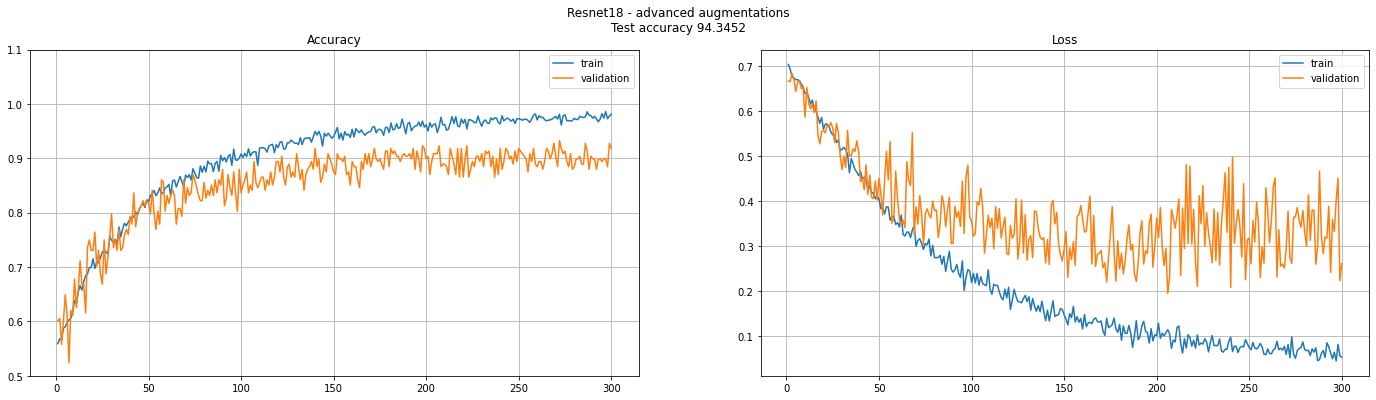

In [ ]:
title = "Resnet18 - advanced augmentations #test"
path_to_save = PATH_REPO_DRIVE 
# path_to_save = None

trainer.plot_history(title, path_to_save);